$$y = A \cdot \sin(2 π f t + φ) + D$$

General formula:

- $A$: amplitude
- $f$: ordinary frequency in cycles per second (period $T=\frac{1}{f}$; angular frequency $ω=2πf$, radians per second)
- $φ$: phase shift in radians (horizontal)
- $D$: amplitude shift (vertical)

For smooth adjustments:

- Interpolate changes in amplitude
- Interpolate changes in frequency and use phase accumulation
- Interpolate changes in phase shift
- Interpolate changes in amplitude shift

In [1]:
from random import random

import numpy as np

from matplotlib import pyplot as plt
from jupyterthemes import jtplot

jtplot.style(context="talk")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


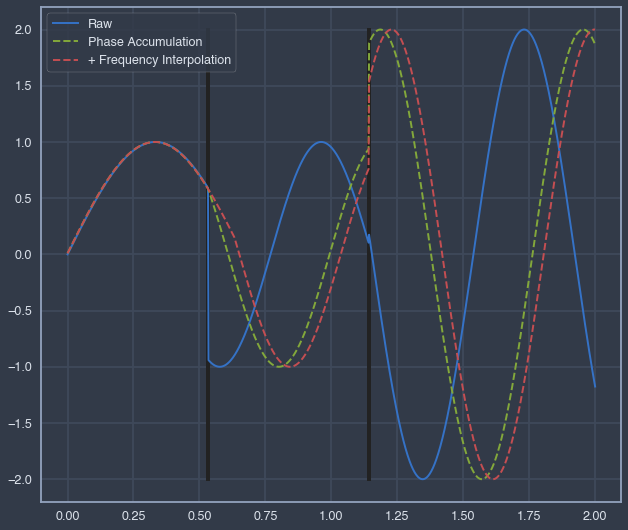

In [2]:
n = 1000

# Timing
t0 = 0
tf = 2
time = np.linspace(t0, tf, n)
dt = time[1] - time[0]

# Dynamic frequency
freq1 = 0.75
freq2 = 1.3
freq1n = 267
freq2n = n - freq1n
freq = np.array([freq1] * freq1n + [freq2] * freq2n)

# Dynamic amplitude
amp1 = 1
amp2 = 2
amp1n = 571
amp2n = n - amp1n
amp = np.array([amp1] * amp1n + [amp2] * amp2n)

# Sinusoid with discontinuities
y = amp * np.sin(2 * np.pi * freq * time)

# Phase (derivative of frequency)
phase = np.cumsum(freq) * dt

# Smooth frequency
s_interp = 50
interp = np.linspace(freq1, freq1, s_interp).tolist()
remainder = n - freq1n - s_interp
freq_interp = np.array([freq1] * freq1n + interp + [freq2] * remainder)
phase_interp = np.cumsum(freq_interp) * dt

# Sinusoid with phase and smoothed frequencies
yphase = amp * np.sin(2 * np.pi * phase)
yintr = amp * np.sin(2 * np.pi * phase_interp)

# Smooth

# TODO: smooth amplitude
# TODO: smooth phase shift
# TODO: smooth amplitude shift


# Frequency change
plt.plot([freq1n / n * tf] * 2, [-2, 2], "k", linewidth=4)
# Amplitude change
plt.plot([amp1n / n * tf] * 2, [-2, 2], "k", linewidth=4)

plt.plot(time, y, label="Raw")
plt.plot(time, yphase, "--", label="Phase Accumulation")
plt.plot(time, yintr, "--", label="+ Frequency Interpolation")


_ = plt.legend()

In [3]:
class SmoothSine:
    def __init__(self, dt, ema_beta=0.9, amplitude=1, frequency=1, phase=0, offset=0):
        self.dt = dt
        self.ema_beta = ema_beta

        self.a = amplitude
        self.f = frequency
        self.p = phase
        self.o = offset

        # Phase accumulation
        self.pa = 0

    def step(self, *, amplitude=None, frequency=None, phase=None, offset=None) -> float:
        b = self.ema_beta

        # Grab new parameters if provided
        amplitude = amplitude if amplitude else self.a
        frequency = frequency if frequency else self.f
        phase = phase if phase else self.p
        offset = offset if offset else self.o

        # Smooth each parameter using exponential moving average
        self.a = (b * self.a) + ((1 - b) * amplitude)
        self.f = (b * self.f) + ((1 - b) * frequency)
        self.p = (b * self.p) + ((1 - b) * phase)
        self.o = (b * self.o) + ((1 - b) * offset)

        # Accumulate phase and return new value
        self.pa += self.f * dt
        return self.a * np.sin(2 * np.pi * self.pa + self.p) + self.o

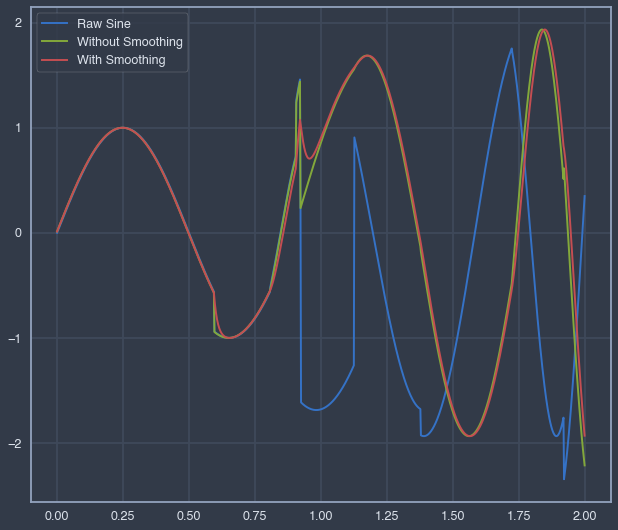

In [4]:
sin0 = SmoothSine(dt, ema_beta=0.0)
sin9 = SmoothSine(dt, ema_beta=0.9)

frequencies = [1]
amplitudes = [1]
phases = [0]
offsets = [0]

y_raw = [
    amplitudes[-1] * np.sin(2 * np.pi * frequencies[-1] * 0 + phases[-1]) + offsets[-1]
]
y0 = [
    sin0.step(
        amplitude=amplitudes[0],
        frequency=frequencies[0],
        phase=phases[0],
        offset=offsets[0],
    )
]
y9 = [
    sin9.step(
        amplitude=amplitudes[0],
        frequency=frequencies[0],
        phase=phases[0],
        offset=offsets[0],
    )
]


def change():
    return random() > 0.998


def rand(a, b):
    return (b - a) * random() + a


for t in time[1:]:
    # Randomly change parameters
    frequencies.append(rand(0.5, 3) if change() else frequencies[-1])
    amplitudes.append(rand(0.5, 3) if change() else amplitudes[-1])
    phases.append(rand(-1, 1) if change() else phases[-1])
    offsets.append(rand(-2, 2) if change() else offsets[-1])

    y_raw.append(
        amplitudes[-1] * np.sin(2 * np.pi * frequencies[-1] * t + phases[-1])
        + offsets[-1]
    )

    y0.append(
        sin0.step(
            amplitude=amplitudes[-1],
            frequency=frequencies[-1],
            phase=phases[-1],
            offset=offsets[-1],
        )
    )
    y9.append(
        sin9.step(
            amplitude=amplitudes[-1],
            frequency=frequencies[-1],
            phase=phases[-1],
            offset=offsets[-1],
        )
    )

plt.plot(time, y_raw, label="Raw Sine")
plt.plot(time, y0, label="Without Smoothing")
plt.plot(time, y9, label="With Smoothing")
_ = plt.legend()

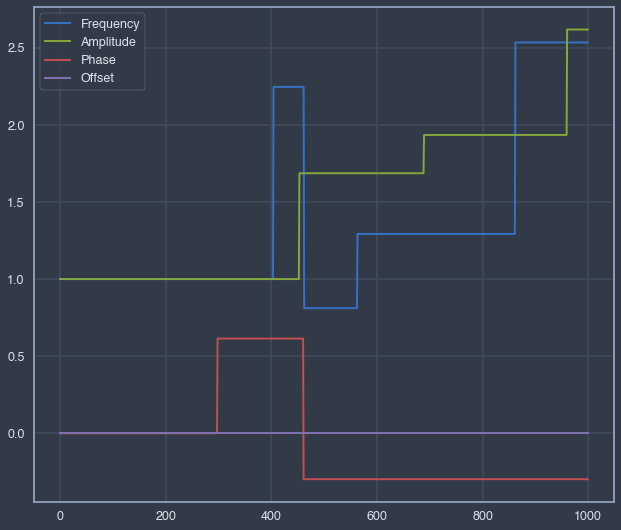

In [5]:
plt.plot(frequencies, label="Frequency")
plt.plot(amplitudes, label="Amplitude")
plt.plot(phases, label="Phase")
plt.plot(offsets, label="Offset")
_ = plt.legend()

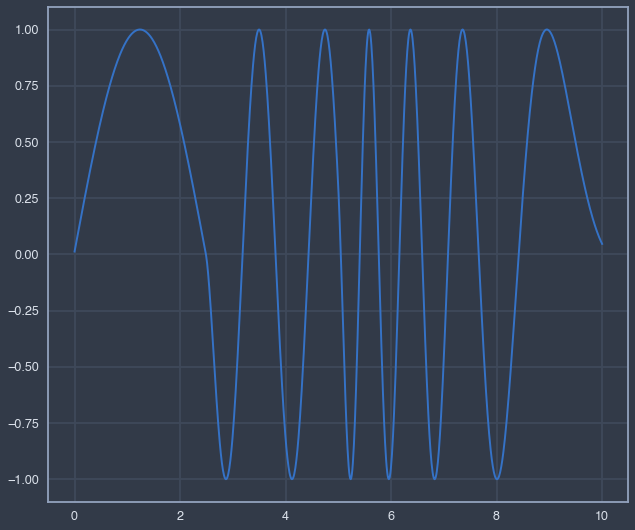

In [10]:
n, t0, tf = 1000, 0, 10
time = np.linspace(t0, tf, n)
freqs = [1] * 250 + [4] * 250 + np.linspace(7.7, 0.25, 500).tolist()

smooth_sin = SmoothSine(dt)

y = [smooth_sin.step(frequency=f) for f in freqs]
_ = plt.plot(time, y)